**Intel® Quickassist Technology (QAT) for SQL Server 2022**

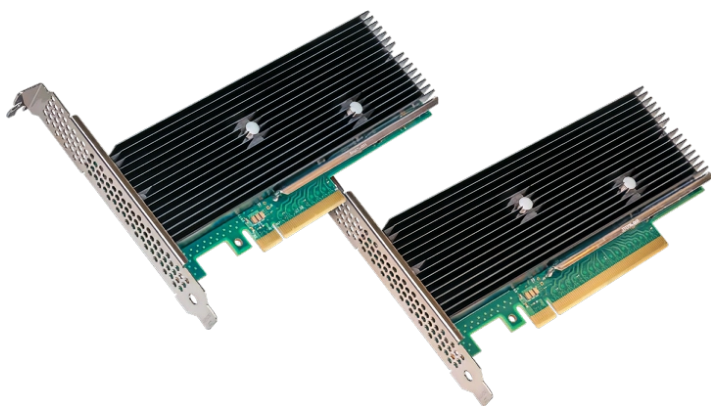

**Introduction**

While many customers leverage the current compression standard, the challenge many have is that the compression ratios are frequently too low to justify the additional compute overhead required to compress the backup files. Many customers in high-volume OLTP environments put their business continuity and disaster recovery (BCDR) strategy at risk by delaying their regular backup schedules in order to remain operational for customer workloads. 

Intel® QuickAssist Technology (QAT) in SQL Server 2022, solves for these challenges by providing hardware acceleration and CPU offload capabilities for enhanced compression and decompression functions. This feature is designed to give tangible improvements both in terms of reduced CPU usage, backup completion times, as well as a reduction in storage consumption. 

The interface for Intel® QuickAssist Technology (QAT) devices leverages a software library called QATZip where the QATZip API maintains a built-in software fallback mechanism. 

The SQL Server 2022 feature provides integrated compression / decompression capabilities by leveraging the QATZip library and the associated Intel® Intelligent Storage ISA-L library. 

💻To get the latest Intel® QuickAssist Technology (QAT) drivers, go to the following location:

**Intel® QuickAssist Technology Landing Page**  
<u>[https://developer.intel.com/quickassist](https://developer.intel.com/quickassist)</u>

QATZip currently supports offloading backups to hardware devices, either through a PCIe adapter or as part of the host server chipset. QATZip also supplys a software based compression capability that can be leveraged if there isn’t hardware available.

The SQL Server 2022 server-scope T-SQL syntax extends the current BACKUP DATABASE command to make it easy for database administrators to choose the desired algorithm to compress backups. Additionally, the sp\_configure configuration option is available to adjust backup compression defaults while introducing a new dynamic management view in order to query the configuration state. 

The implementation of this feature surfaces appropriate error log and informational messaging to troubleshoot the Intel QAT configuration as well as being able to track the benefits of the Intel® QuickAssist Technology (QAT) compression feature over time by surfacing the compression algorithm history in the msdb database.

**<u>Step 0 - Enable the 'hardware offload' feature for SQL Server 2022</u>**

Intel® QuickAssist Technology (QAT) for SQL Server 2022 requires that you first enable the 'hardware offload' feature, which gives SQL Server the ability to load the approved drivers into the SQL Server process space.

In [ ]:
--Ensure you are able to view the advanced options for SQL Server.
sp_configure 'show advanced options', 1
GO
RECONFIGURE
GO

In [5]:
--Enable the hardware offload feature for SQL Server 2022.
--Note: If this feature is disabled all acclerator for SQL Server 2022 will also be disabled.
sp_configure 'hardware offload enabled', 1
GO
RECONFIGURE
GO

Configuration option 'hardware offload enabled' changed from 1 to 1. Run the RECONFIGURE statement to install.

Commands completed successfully.

Total execution time: 00:00:00.005

**Step 1 - \*\*RESTART SQL SERVER SERVICE\*\***

**Step 2. Enable the Intel® QuickAssist Technology (QAT) Feature for hardware and software failback support**

The below statement persists a bit on the SQL Server boot page to load QAT binaries at startup.  
After executing the BELOW statement, users should restart SQL Server to load the Intel® QuickAssist Technology (QAT) binaries into the SQL Server process space.

**⚠ Note:** This bit also carries over when SQL Server completes a failover from one node to another.

In [6]:
--Enable Intel® QuickAssist Technology (QAT) hardware mode:
ALTER SERVER CONFIGURATION
SET HARDWARE_OFFLOAD = ON (ACCELERATOR = QAT)

Hardware offload configuration hasn't changed. Current configuration (0x1) and mode (0x0). No action required.

Total execution time: 00:00:00.023

**Step 3. \*\*RESTART THE SQL SERVER SERVICE\*\* TO ENABLE THE INTEL® QUICKASSIST TECHNOLOGY (QAT) BINARIES**

**Step 4a. Leveraging the sys.dm\_server\_hardware\_offload\_config Dynamic Management View (DMV)**

Confirm the hardware (AUTO) state of the Intel® QuickAssist Technology (QAT) feature for SQL Server 2022.

The sys.dm\_server\_hardware\_offload\_config DMV below will expose all offloading potentials and the configuration, one row per accelerator.

In [7]:
--Confirm the state of the Intel® QuickAssist Technology (QAT) feature for SQL Server 2022
--The sys.dm_server_hardware_offload_config DMV below will expose all offloading potentials and the configuration, one row per accelerator

SELECT * FROM sys.dm_server_hardware_offload_config
GO

(1 row affected)

Total execution time: 00:00:00.016

accelerator,accelerator_desc,config,config_in_use,mode,mode_desc,mode_reason,mode_reason_desc,accelerator_hardware_present,accelerator_library_version,accelerator_driver_version
QAT,Intel(R) QuickAssist Technology,1,1,2,HARDWARE,12,HARDWARE_MODE_ENTERPRISE_SKU,1,"QATZip: 1.8.0.10, ISA-L: 2.30.0.0",icp_qat: 3.2.0.9


**Step 4b. (OPTIONAL) Query sys.configurations**

You can use the query below to examine the output from sys.configurations, which can be adjusted to influence backup compression behavior such as the algorith defaults, compression enablement, and other configurations.

In [ ]:
--CHECK ALL THE sys.configurations
SELECT value_in_use, value, *,
"Step description" =
CASE 
	WHEN is_advanced = 1 THEN 'REQUIRES RESTART'
ELSE 'NO RESTART NEEDED'
END
FROM sys.configurations
WHERE
(name = 'show advanced options'
OR name = 'backup compression default'
OR name = 'backup compression algorithm'
OR name = 'hardware offload enabled'
OR name = 'hardware offload config'
OR name = 'hardware offload mode')
GO

For the above results the configuration descriptions apply:

- **backup compression default** - Enable compression of backups by default
- **hardware offload enabled** - Required to enable accelerators for hardware offloading, all hardware offloading can be enabled / disabled with this global switch.
- **hardware offload config** - Configure hardware offload accelerator to on or off, 1 bit per accelerator. The result bitwise value represents the enabled accelerators for this instance.
- **hardware offload mode** - Configure hardware offload accelerator mode auto or software, 1 bit per accelerator.
- **backup compression algorithm** - default backup compression algorithm when algorithm clause is not specified on the BACKUP .. WITH COMPRESSION command.

**Step 5. Examine the SQL Server error log**

Examine the SQL Server error log for Intel® QuickAssist Technology (QAT) entries which can be helpful for troubleshooting.  
Notice the library version for Intel QATZip, the Kerenl Driver version, the Intel Storage Acceleration Library (ISA-L), and the Intel(R) QuickAssist Technology (QAT) success messaging.

In [1]:
sp_readerrorlog 0,1,'Intel'

(8 rows affected)

Total execution time: 00:00:00.164

LogDate,ProcessInfo,Text
2022-07-27 22:50:20.700,Server,"System Manufacturer: 'Intel Corporation', System Model: 'M50CYP2SBSTD'."
2022-07-27 22:50:21.560,Server,Detected Intel(R) QuickAssist Compression Library QATZip: 1.8.0.10.
2022-07-27 22:50:21.560,Server,Detected Intel(R) QuickAssist Kernel Driver icp_qat: 3.2.0.9.
2022-07-27 22:50:21.560,Server,Detected Intel(R) Storage Acceleration Library ISA-L: 2.30.0.0.
2022-07-27 22:50:21.560,Server,Intel(R) QuickAssist Technology (QAT) initialization succeeded.
2022-07-27 22:50:21.560,Server,Intel(R) QuickAssist Technology (QAT) hardware detected on the system.
2022-07-27 22:50:21.560,Server,Intel(R) QuickAssist Technology (QAT) will be used in hardware mode.
2022-07-27 22:50:21.560,Server,Intel(R) QuickAssist Technology (QAT) session sucessfully created.


**Step 6. Begin Performance Monitor (perfmon) analysis**

Open perfmon and trend the performance monitor counters for the following:

**Processor (Total)**

- % Processor Time
- % Privileged Time

**Process (sqlservr)**

- % Processor Time
- % Privileged Time

**LogicalDisk (Total, and all disks)**

- Avg. Disk Bytes/Read
- Avg. Disk Bytes/Write

**PhysicalDisk (Total, and all disks)**

- Avg. Disk Bytes/Read
- Avg. Disk Bytes/Write

**SQL Server, Backup Device object**

- Device Throughput Bytes/sec \- Throughput of read and write operations (in bytes per second) for a backup device used when backing up or restoring databases. This counter exists only while the backup or restore operation is executing.

**SQL Server, Databases object**  

- Backup/Restore Throughput/sec - Read/write throughput for backup and restore operations of a database per second. For example, you can measure how the performance of the database backup operation changes when more backup devices are used in parallel or when faster devices are used. Throughput of a database backup or restore operation allows you to determine the progress and performance of your backup and restore operations.

**⚠ Note:** You may need to scale the performance counters, it is recommended to pause perfmon for each SQL Server backup example to make it easier to compare the processor overhead, disk throughput, and elapsed time for each result.

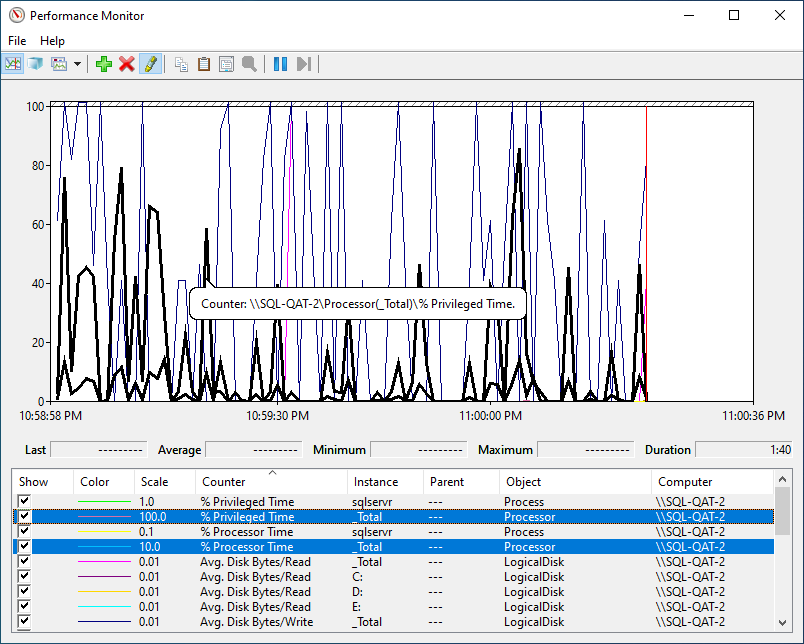

**Step 7a. Leverage Intel® QuickAssist Technology (QAT) Backup compression and compare results**

Once SQL Server has loaded the QAT binaries into SQL process space, and this has been verified - users can execute the BACKUP statement with ALGORITHM set to **QAT\_DEFLATE** or they can use **MS\_XPRESS** which is the default compression algorithm.

**❗ IMPORTANT:** The performance of the **QAT\_DEFLATE** algorithm in terms of hardware vs. software-only mode and compared to **MS\_XPRESS,** will vary based on a number of factors.  
The factors of the compute capabilities of the host SQL Server, the workload pressure the host system may be under during backup executions, and the available memory and processing power of the **Intel® QuickAssist Technology (QAT)** hardware device are all factors that could impact the performance of the leveraged compression algorithm.

In [ ]:
--a. Next, backup using the SQL Server 2022 QAT compression algorithm:
--Remember to run perfmon during the backup execution and pause when the backup completes.
BACKUP DATABASE [TicketReservations]
TO DISK='D:\backups\QAT-DEFLATE_hw_0722022_1107pm.bak'
WITH FORMAT, COMPRESSION (ALGORITHM = QAT_DEFLATE)
GO

**Step 7b. Make note of the Informational Backup Progress for** **QAT\_DEFLATE in notepad.**

**Step 8a. Leverage SQL Server default (MS\_XPRESS) backup compression and record the results**

Users can specify backups can be completed with the BACKUP statement ALGORITHM set to **QAT\_DEFLATE** or they can use **MS\_XPRESS** which is also the default compression algorithm.

**⚠** The syntax for the BACKUP statement with optional ALGORITHM parameter for **MS\_XPRESS**:

In [ ]:
--b. First, backup using the SQL Server default:
BACKUP DATABASE [TicketReservations]
TO DISK='D:\backups\MS-XPRESS_07282022_1114am.bak'
WITH FORMAT, COMPRESSION (ALGORITHM = MS_XPRESS)
GO

**Step 8b. Make note of the Informational Backup Progress for** **MS\_XPRESS in notepad.**

**Step 9. Enable the Intel® QuickAssist Technology (QAT) Feature for software-only support**

The below statement persists a bit on the SQL Server boot page to load the QAT binaries for **<u>software-only</u>** use.

After executing the BELOW statement, users should restart SQL Server to load the Intel® QuickAssist Technology (QAT) binaries into the SQL Server process space.

In [4]:
--Enable Intel® QuickAssist Technology (QAT) hardware mode:
ALTER SERVER CONFIGURATION
SET HARDWARE_OFFLOAD = ON  (ACCELERATOR = QAT, MODE=SOFTWARE)

Hardware offload configuration has changed. Current configuration (0x1) and mode (0x0). New configuration (0x1) and mode (0x1). Restart SQL Server for the new configuration to take effect.

Total execution time: 00:00:00.002

**Step 10 - \*\*RESTART SQL SERVER SERVICE\*\***

**Step 11. Leveraging the sys.dm\_server\_hardware\_offload\_config Dynamic Management View (DMV)**

Confirm the **<u>software-only</u>** mode of the Intel® QuickAssist Technology (QAT) feature for SQL Server 2022.

The sys.dm\_server\_hardware\_offload\_config DMV below will expose all offloading potentials and the configuration, one row per accelerator and make note of the **mode\_reason\_desc** column below:

In [5]:
SELECT * FROM sys.dm_server_hardware_offload_config
GO

(1 row affected)

Total execution time: 00:00:00.015

accelerator,accelerator_desc,config,config_in_use,mode,mode_desc,mode_reason,mode_reason_desc,accelerator_hardware_present,accelerator_library_version,accelerator_driver_version
QAT,Intel(R) QuickAssist Technology,1,1,1,SOFTWARE,11,SOFTWARE_MODE_FORCE_OVERRIDE,1,"QATZip: 1.8.0.10, ISA-L: 2.30.0.0",icp_qat: 3.2.0.9


**Step 12a. Backup using Intel® QuickAssist Technology (QAT) software-only backup compression**

**❗ IMPORTANT:** The performance of the QAT\_DEFLATE algorithm software vs. hardware and compared to MS\_XPRESS will vary based on the compute capabilities of the host system,

the compute pressure the host system is under, and the available memory and compute of the hardware device that is offloading to.

The syntax for the BACKUP statement with optional ALGORITHM parameter for QAT\_DEFLATE:

In [ ]:
--c. Next, backup using the SQL Server 2022 QAT compression software-only algorithm:
BACKUP DATABASE [TicketReservations]
TO DISK='D:\backups\QAT-DEFLATE_sw_07262022_1142am.bak'
WITH FORMAT, COMPRESSION (ALGORITHM = QAT_DEFLATE)
GO

**Step 12b. Make note of the Informational Backup Progress for** **QAT\_DEFLATE in notepad and compare the previous results.**

**Step 13. Leveraging 'RESTORE HEADERONLY'**

Restore headeronly displays the compression algorithm in the last column. If the backup is a Intel® QuickAssist Technology (QAT) compressed backup, we will see the QAT\_DEFLATE algorithm displayed in the column header. 

**⚠ Note:** It is required to have the Intel® QuickAssist Technology (QAT) drivers loaded on the destination SQL Server 2022 system in order to complete a restore for an Intel® QuickAssist Technology (QAT) compressed backup.  
  
In the tabular results, scroll to the end to make note of the **CompressionAlgorithm** being used for each restore.

In [9]:
RESTORE HEADERONLY --MS_XPRESS example
FROM DISK='D:\backups\MS-XPRESS_07282022_1114am.bak'
GO

RESTORE HEADERONLY --QAT_DEFLATE example
FROM DISK='D:\backups\QAT-DEFLATE_hw_0722022_1107pm.bak'
GO

(1 row affected)

(1 row affected)

Total execution time: 00:00:00.034

BackupName,BackupDescription,BackupType,ExpirationDate,Compressed,Position,DeviceType,UserName,ServerName,DatabaseName,DatabaseVersion,DatabaseCreationDate,BackupSize,FirstLSN,LastLSN,CheckpointLSN,DatabaseBackupLSN,BackupStartDate,BackupFinishDate,SortOrder,CodePage,UnicodeLocaleId,UnicodeComparisonStyle,CompatibilityLevel,SoftwareVendorId,SoftwareVersionMajor,SoftwareVersionMinor,SoftwareVersionBuild,MachineName,Flags,BindingID,RecoveryForkID,Collation,FamilyGUID,HasBulkLoggedData,IsSnapshot,IsReadOnly,IsSingleUser,HasBackupChecksums,IsDamaged,BeginsLogChain,HasIncompleteMetaData,IsForceOffline,IsCopyOnly,FirstRecoveryForkID,ForkPointLSN,RecoveryModel,DifferentialBaseLSN,DifferentialBaseGUID,BackupTypeDescription,BackupSetGUID,CompressedBackupSize,Containment,KeyAlgorithm,EncryptorThumbprint,EncryptorType,LastValidRestoreTime,TimeZone,CompressionAlgorithm
NULL,NULL,1,NULL,1,1,2,NORTHAMERICA\dpless,SQL-QAT-2\GD6,TicketReservations,956,2022-07-25 23:57:45.000,11497362432,322000007482200013,340000000431100001,340000000430800001,340000000427200001,2022-07-27 23:27:25.000,2022-07-27 23:27:33.000,52,0,1033,196609,150,4608,16,0,722,SQL-QAT-2,512,00d9686b-d8f4-4fbf-b5d5-2522bc6b91bb,82a42f3d-5fcd-460f-ae8a-c252d58a5a1f,SQL_Latin1_General_CP1_CI_AS,c273f057-4c8d-46f2-ae8f-732b12620fe4,0,0,0,0,0,0,0,0,0,0,82a42f3d-5fcd-460f-ae8a-c252d58a5a1f,NULL,FULL,NULL,NULL,Database,c51ca126-3c41-44ba-b1b6-18dbd2a5341e,1112939770,0,NULL,NULL,NULL,NULL,-96,MS_XPRESS


BackupName,BackupDescription,BackupType,ExpirationDate,Compressed,Position,DeviceType,UserName,ServerName,DatabaseName,DatabaseVersion,DatabaseCreationDate,BackupSize,FirstLSN,LastLSN,CheckpointLSN,DatabaseBackupLSN,BackupStartDate,BackupFinishDate,SortOrder,CodePage,UnicodeLocaleId,UnicodeComparisonStyle,CompatibilityLevel,SoftwareVendorId,SoftwareVersionMajor,SoftwareVersionMinor,SoftwareVersionBuild,MachineName,Flags,BindingID,RecoveryForkID,Collation,FamilyGUID,HasBulkLoggedData,IsSnapshot,IsReadOnly,IsSingleUser,HasBackupChecksums,IsDamaged,BeginsLogChain,HasIncompleteMetaData,IsForceOffline,IsCopyOnly,FirstRecoveryForkID,ForkPointLSN,RecoveryModel,DifferentialBaseLSN,DifferentialBaseGUID,BackupTypeDescription,BackupSetGUID,CompressedBackupSize,Containment,KeyAlgorithm,EncryptorThumbprint,EncryptorType,LastValidRestoreTime,TimeZone,CompressionAlgorithm
NULL,NULL,1,NULL,1,1,2,NORTHAMERICA\dpless,SQL-QAT-2\GD6,TicketReservations,956,2022-07-25 23:57:45.000,11497296896,322000007482200013,340000000418300001,340000000418000001,340000000410400001,2022-07-27 23:09:04.000,2022-07-27 23:09:22.000,52,0,1033,196609,150,4608,16,0,722,SQL-QAT-2,512,00d9686b-d8f4-4fbf-b5d5-2522bc6b91bb,82a42f3d-5fcd-460f-ae8a-c252d58a5a1f,SQL_Latin1_General_CP1_CI_AS,c273f057-4c8d-46f2-ae8f-732b12620fe4,0,0,0,0,0,0,0,0,0,0,82a42f3d-5fcd-460f-ae8a-c252d58a5a1f,NULL,FULL,NULL,NULL,Database,766df957-7bc6-4782-9f33-96595e81b419,943983833,0,NULL,NULL,NULL,NULL,48,QAT_DEFLATE


**Step 14a. Leveraging** **Intel® Quickassist Technology (QAT) and** **RESTORE DATABASE**

Customers will witness similar performance improvements using RESTORE DATABASE and the Intel® Quickassist Technology (QAT) drivers. The same algorithm that was used to backup the database will be leveraged to restore the database.

**❗ IMPORTANT:** The Intel® QuickAssist Technology (QAT) drivers are required to restore an Intel® QuickAssist Technology (QAT) compressed backup.

💻To get the latest Intel® QuickAssist Technology (QAT) drivers, go to the following location:

**Intel® QuickAssist Technology Landing Page**  
<u>[https://developer.intel.com/quickassist](https://developer.intel.com/quickassist)</u>

In [ ]:
--Restore Database performance
/*Similar performance gains can be observed using the QAT algorithm for the RESTORE DATABASE command.*/

RESTORE DATABASE [TicketReservations]
FROM DISK='D:\backups\MS-XPRESS_07262022_1115am.bak'
WITH REPLACE
GO

In [ ]:
RESTORE DATABASE [TicketReservations]
FROM DISK='D:\backups\QAT-DEFLATE_hw_07262022_1117am.bak'
WITH REPLACE
GO

**Step 14b. Make note of the Informational Backup Progress for the MS\_XPRESS and** **QAT\_DEFLATE restores in notepad and compare the previous results.**

**Step. 15. Leverage the msdb database for backup history**

The msdb database helps persist backup history through the use of the backupset, backupmediafamily, and backupmediaset tables.

In SQL Server 2022, we have expanded the backupset table to add the compression algorithm to help customers track the health of their backup performance over time.

In [1]:
SELECT bs.database_name,
backuptype = CASE
WHEN bs.type = 'D'
AND bs.is_copy_only = 0 THEN 'Full Database'
WHEN bs.type = 'D'
AND bs.is_copy_only = 1 THEN 'Full Copy-Only Database'
WHEN bs.type = 'I' THEN 'Differential database backup'
WHEN bs.type = 'L' THEN 'Transaction Log'
WHEN bs.type = 'F' THEN 'File or filegroup'
WHEN bs.type = 'G' THEN 'Differential file'
WHEN bs.type = 'P' THEN 'Partial'
WHEN bs.type = 'Q' THEN 'Differential partial'
END + ' Backup',
CASE bf.device_type
WHEN 2 THEN 'Disk'
WHEN 5 THEN 'Tape'
WHEN 7 THEN 'Virtual device'
WHEN 9 THEN 'Azure Storage'
WHEN 105 THEN 'A permanent backup device'
ELSE 'Other Device'
END AS DeviceType,
bms.software_name AS backup_software,
bs.recovery_model,
bs.compatibility_level,
BackupStartDate = bs.Backup_Start_Date,
BackupFinishDate = bs.Backup_Finish_Date, DATEDIFF(ms, backup_start_date, backup_finish_date) AS ms_taken,
LatestBackupLocation = bf.physical_device_name,
backup_size_mb = CONVERT(decimal(10, 2), bs.backup_size/1024./1024.),
compressed_backup_size_mb = CONVERT(decimal(10, 2), bs.compressed_backup_size/1024./1024.),
(CONVERT(decimal(10, 2), bs.backup_size/1024./1024.)) - (CONVERT(decimal(10, 2), bs.compressed_backup_size/1024./1024.)) as compression_savings,
bs.compression_algorithm
--bs.flags, bs.description, bms.description, bs.name, bms.name
FROM msdb.dbo.backupset bs
LEFT OUTER JOIN msdb.dbo.backupmediafamily bf ON bs.[media_set_id] = bf.[media_set_id]
INNER JOIN msdb.dbo.backupmediaset bms ON bs.[media_set_id] = bms.[media_set_id]
WHERE bs.backup_start_date > DATEADD(HOUR, -12, sysdatetime()) --only look at last 12 hours
ORDER BY bs.Backup_Start_Date DESC, bs.database_name ASC

(5 rows affected)

Total execution time: 00:00:00.011

database_name,backuptype,DeviceType,backup_software,recovery_model,compatibility_level,BackupStartDate,BackupFinishDate,ms_taken,LatestBackupLocation,backup_size_mb,compressed_backup_size_mb,compression_savings,compression_algorithm
TicketReservations,Full Database Backup,Disk,Microsoft SQL Server,FULL,150,2022-08-01 23:31:00.000,2022-08-01 23:31:08.000,8000,D:\backups\MS-XPRESS_08022022_1130pm.bak,10964.93,1061.40,9903.53,MS_XPRESS
TicketReservations,Full Database Backup,Disk,Microsoft SQL Server,FULL,150,2022-08-01 23:27:42.000,2022-08-01 23:28:00.000,18000,D:\backups\QAT-DEFLATE_hw_08022022_1127pm.bak,10964.93,900.28,10064.65,QAT_DEFLATE
TicketReservations,Full Database Backup,Disk,Microsoft SQL Server,FULL,150,2022-08-01 23:26:41.000,2022-08-01 23:26:59.000,18000,D:\backups\QAT-DEFLATE_sw_08022022_1126pm.bak,10964.93,900.28,10064.65,QAT_DEFLATE
TicketReservations,Full Database Backup,Disk,Microsoft SQL Server,FULL,150,2022-08-01 15:26:53.000,2022-08-01 15:27:06.000,13000,D:\backups\QAT-DEFLATE_hw_08012022_1117am.bak,10964.86,900.27,10064.59,QAT_DEFLATE
TicketReservations,Full Database Backup,Disk,Microsoft SQL Server,FULL,150,2022-08-01 15:26:34.000,2022-08-01 15:26:41.000,7000,D:\backups\MS-XPRESS_08012022_1115am.bak,10964.86,1061.39,9903.47,MS_XPRESS
